# Import Libraries

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from skimage import data, io
from skimage.filters.rank import median
import enum

# Convert colored images to grayscale
<b>grayscale value = 0.33R + 0.33G + 0.33B</b>

In [2]:
def convert_to_grayscale(img):
    new_img = np.zeros((img.shape[0],img.shape[1]), dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img[i][j] = (img[i][j][0]*0.33) + (img[i][j][1]*0.33) + (img[i][j][2]*0.33)
            new_img[i][j] = int(new_img[i][j])
                
    return new_img;

In [3]:
def threshold(img, th):
    result = np.zeros(img.shape, dtype= np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            val = img[i][j]
            if val > th:
                result[i][j] = 255;
    return result

# Focus only on regions of interest in the image

In [4]:
def img_and(img,operand):
    new_img = np.zeros(img.shape, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if operand[i][j] != 0:
                new_img[i][j] = img[i][j]
    return new_img

def remove_disturbance(img):
    logical_operand = io.imread('assets/logical_operand.png')
    logical_operand = convert_to_grayscale(logical_operand)
    return img_and(img,logical_operand)

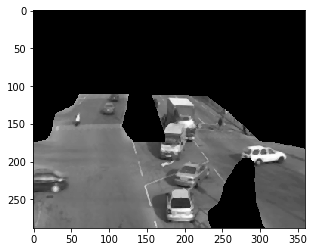

In [59]:
frame1 = io.imread('assets/frame13.png')
frame2 = io.imread('assets/frame14.png')


frame1_gray = convert_to_grayscale(frame1);
frame2_gray = convert_to_grayscale(frame2);


frame1_smooth = median(frame1_gray, np.ones((3,3))/9)
frame2_smooth = median(frame2_gray, np.ones((3,3))/9)


frame1_focussed = remove_disturbance(frame1_smooth)
frame2_focussed = remove_disturbance(frame2_smooth)


plt.imshow(frame1_focussed, 'gray')

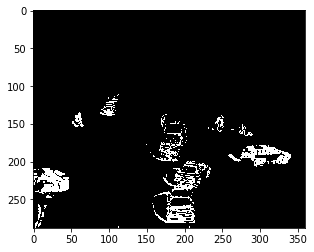

In [60]:
def frame_difference(f1,f2):
    result = np.zeros(f1.shape, dtype=np.uint8)
    for i in range(f1.shape[0]):
        for j in range(f2.shape[1]):
            new_val = abs(int(f2[i][j]) - int(f1[i][j])) #change uint8 to int and allow -ve values
            if new_val > 0: #threshold to remove noise
                result[i][j] = new_val;
    return result


frame1_focussed = remove_disturbance(frame1_focussed)
frame2_focussed = remove_disturbance(frame2_focussed)


moving_objects = frame_difference(frame1_focussed, frame2_focussed)
moving_objects = threshold(moving_objects, 10)

plt.imshow(moving_objects, 'gray')



# Extract all vehicles

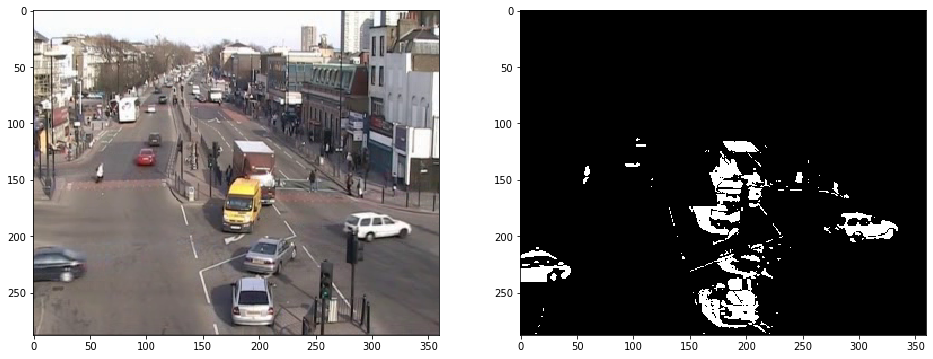

In [61]:
background = io.imread('assets/background.png')
background = convert_to_grayscale(background)
background = remove_disturbance(background)

def extract_foreground(img,background_img):
    result = np.zeros(img.shape, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result[i][j] = abs(int(img[i][j]) - int(background_img[i][j]))
    return result

foreground = extract_foreground(frame1_focussed,background)
foreground = threshold(foreground,50)

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 8)
ax1.imshow(frame1 ,cmap=plt.cm.gray)
ax2.imshow(foreground ,cmap=plt.cm.gray)


plt.show()



# Region Seperation

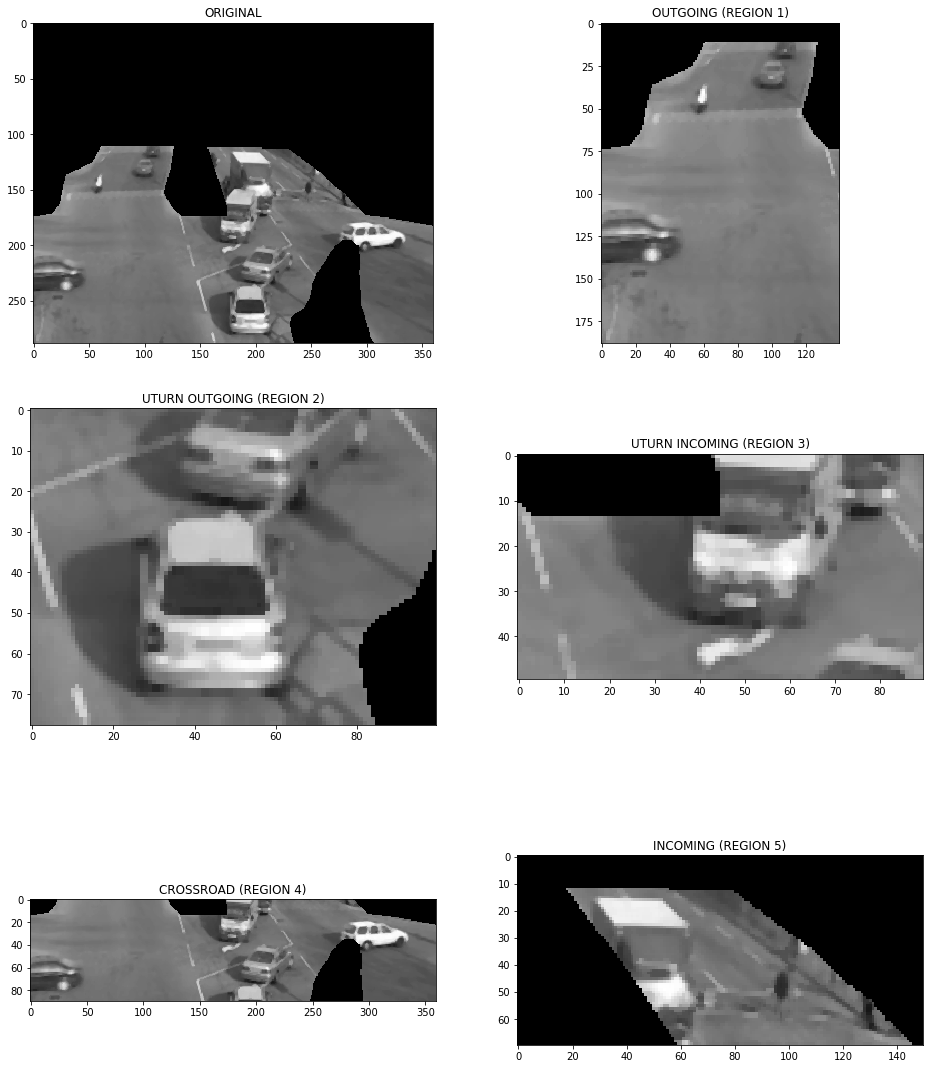

In [77]:
def crop_first_region(imgs):
    cropped_imgs = []
    for imm in imgs:
        cropped_imgs.append(img[100:,0:140])
    return cropped_imgs

def crop_second_region(imgs):
    cropped_imgs = []
    for img in imgs:
         cropped_imgs.append(img[210:,150:250])
    return cropped_imgs

def crop_third_region(imgs):
    cropped_imgs = []
    for img in imgs:
        cropped_imgs.append(img[160:210,130:220])
    return cropped_imgs

def crop_fourth_region(imgs):
    cropped_imgs = []
    for img in imgs:
        cropped_imgs.append(img[160:250,:])
    return cropped_imgs

def crop_fifth_region(imgs):
    region5_operand = io.imread('assets/region5_operand.png')
    region5_operand = convert_to_grayscale(region5_operand)
    cropped_imgs = []
    for img in imgs:
        new_img= img_and( img,region5_operand)[100:170,150:300]
        cropped_imgs.append(new_img)
    return cropped_imgs



[region1] = crop_first_region([frame1_focussed])
[region2] = crop_second_region([frame1_focussed])
[region3] = crop_third_region([frame1_focussed])
[region4] = crop_fourth_region([frame1_focussed])
[region5] = crop_fifth_region([frame1_focussed])


fig, ((ax1,ax2) , (ax3,ax4), (ax5,ax6)) = plt.subplots(3,2)
fig.set_size_inches(16,20)
ax1.imshow(frame1_focussed, 'gray')
ax2.imshow(region1, 'gray')
ax3.imshow(region2, 'gray')
ax4.imshow(region3, 'gray')
ax5.imshow(region4, 'gray')
ax6.imshow(region5, 'gray')

ax1.set_title("ORIGINAL")
ax2.set_title("OUTGOING (REGION 1)")
ax3.set_title("UTURN OUTGOING (REGION 2)")
ax4.set_title("UTURN INCOMING (REGION 3)")
ax5.set_title("CROSSROAD (REGION 4)")
ax6.set_title("INCOMING (REGION 5)")


plt.show()

# Traffic Finite State Machine


- State 1: <b>INCOMING</b> and <b>OUTGOING</b> roads can be green simultaneously, but no other road can be green
<br>
- State 2: Once moving cars in <b>INCOMING</b> and <b>OUTGOING</b> are <i>LOW</i> they will turn red
<br>
- State 2: If <b>UTURN</b> stopped cars are <i>HIGH</i> then both will be green and will remain green until moving cars are low
<br>
- State 3: Then, only <b>CROSSROAD</b> will turn green and will remain green until moving cars are <i>LOW</i>, then it will return to State 1
<br>
<br>

# Conditions
<i>Before any traffic light turns red, it will turn yellow first for 3 seconds to prevent sudden unexpected stops.</i>
<br>
<i>If one car is present in any red lit region, it can wait for a maximum of 30 seconds.</i>
<br>

# Finite State Machine Diagram
![image](./state_machine.png)

In [78]:
def img_get_avg(region):
    val_sum = 0;
    for i in range(region.shape[0]):
        for j in range(region.shape[1]):
            val_sum += region[i][j]
    return val_sum / (region.shape[0] * region.shape[1])


### Assume state 3

In [79]:




[region1_moving, region1_foreground] = crop_first_region([moving_objects,foreground])
[region2_moving, region2_foreground] = crop_second_region([moving_objects,foreground])
[region3_moving, region3_foreground] = crop_third_region([moving_objects,foreground])
[region4_moving, region4_foreground] = crop_fourth_region([moving_objects,foreground])
[region5_moving, region5_foreground] = crop_fifth_region([moving_objects,foreground])






Text(0.5, 1.0, 'region5 Foreground')

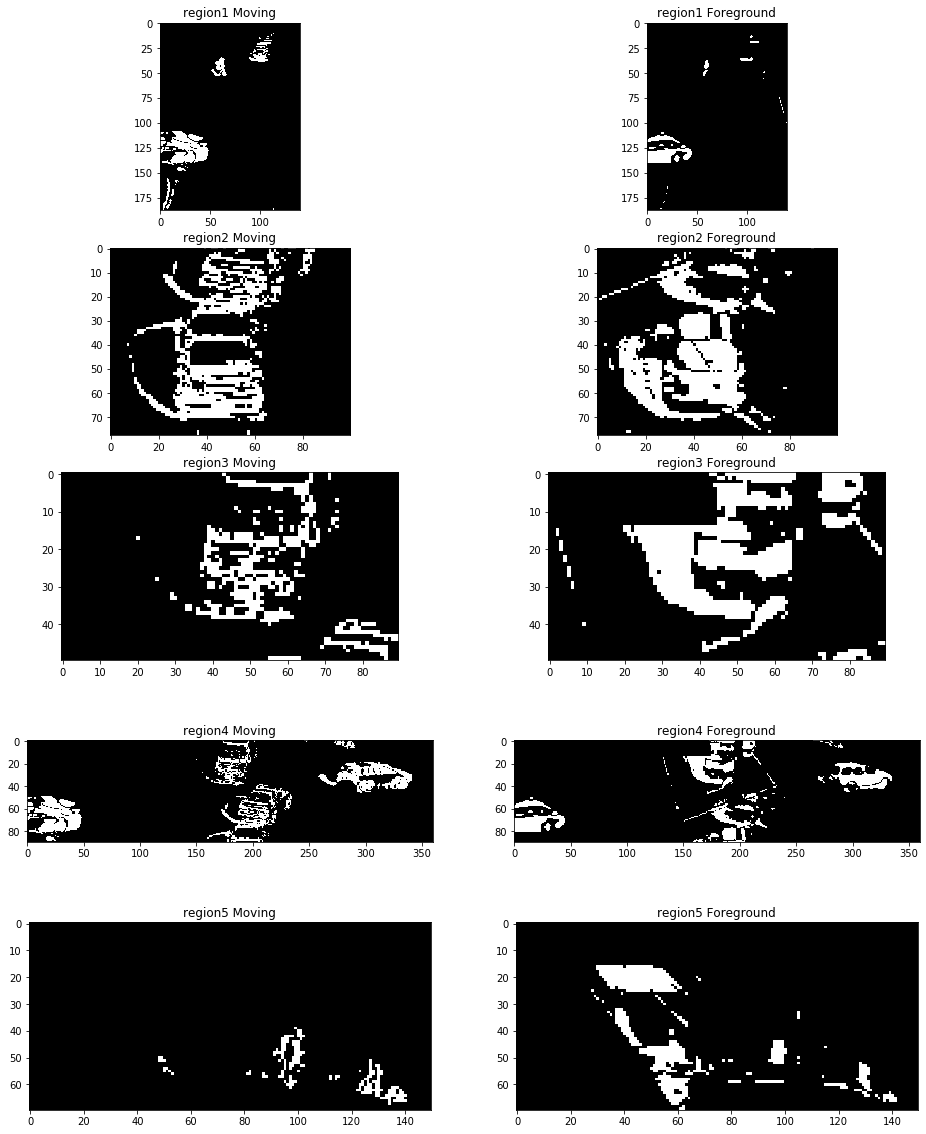

In [80]:
fig, ((ax1,ax2) , (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2)
fig.set_size_inches(16,20)

ax1.imshow(region1_moving, 'gray')
ax2.imshow(region1_foreground, 'gray')

ax3.imshow(region2_moving, 'gray')
ax4.imshow(region2_foreground, 'gray')

ax5.imshow(region3_moving, 'gray')
ax6.imshow(region3_foreground, 'gray')

ax7.imshow(region4_moving, 'gray')
ax8.imshow(region4_foreground, 'gray')

ax9.imshow(region5_moving, 'gray')
ax10.imshow(region5_foreground, 'gray')

ax1.set_title("region1 Moving")
ax2.set_title("region1 Foreground")

ax3.set_title("region2 Moving")
ax4.set_title("region2 Foreground")

ax5.set_title("region3 Moving")
ax6.set_title("region3 Foreground")

ax7.set_title("region4 Moving")
ax8.set_title("region4 Foreground")

ax9.set_title("region5 Moving")
ax10.set_title("region5 Foreground")


OUTGOING MOVING: 13
OUTGOING STOPPED: -6

OUTGOING UTURN MOVING: 46
OUTGOING UTURN STOPPED: 10

INCOMING UTURN MOVING: 28
INCOMING UTURN STOPPED: 27

CROSSROAD MOVING: 25
CROSSROAD STOPPED: -1

INCOMING MOVING: 4
INCOMING STOPPED: 12



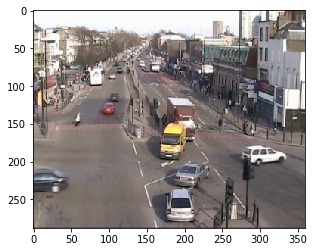

In [81]:
r1_moving_score = img_get_avg(region1_moving)
r1_stopped_score = img_get_avg(region1_foreground) - r1_moving_score # foreground includes moving cars

r2_moving_score = img_get_avg(region2_moving)
r2_stopped_score = img_get_avg(region2_foreground) - r2_moving_score

r3_moving_score = img_get_avg(region3_moving)
r3_stopped_score = img_get_avg(region3_foreground) - r3_moving_score

r4_moving_score = img_get_avg(region4_moving)
r4_stopped_score = img_get_avg(region4_foreground) - r4_moving_score

r5_moving_score = img_get_avg(region5_moving)
r5_stopped_score = img_get_avg(region5_foreground) - r5_moving_score

plt.imshow(frame1)


print("OUTGOING MOVING: %d" % r1_moving_score)
print("OUTGOING STOPPED: %d\n" % r1_stopped_score)

print("OUTGOING UTURN MOVING: %d" % r2_moving_score)
print("OUTGOING UTURN STOPPED: %d\n" % r2_stopped_score)

print("INCOMING UTURN MOVING: %d" % r3_moving_score)
print("INCOMING UTURN STOPPED: %d\n" % r3_stopped_score)

print("CROSSROAD MOVING: %d" % r4_moving_score)
print("CROSSROAD STOPPED: %d\n" % r4_stopped_score)

print("INCOMING MOVING: %d" % r5_moving_score)
print("INCOMING STOPPED: %d\n" % r5_stopped_score)

# Observations
- Outgoing region of interest had a stopped score of <0 and a small moving score, conforms with the traffic snapshot used
- Outgoing Uturn recorded a high score even though no cars are in the outgoing uturn. However, the car moving in crossroad is passing through the outgoing uturn region, therefore in finding a decision, crossroad score will be subtracted from uturn regions during state 3 only to prevent the error occuring from region overlap
- Crossroad moving has a non-zero score

# Creating the module for this junction
### INPUTS: current frame - previous frame - background image - current state
### OUTPUTS: best next state

In [88]:
class State(enum.Enum):
    state1 = 1
    state2 = 2
    state3 = 3

def preprocess_image(img):
    img_gray = convert_to_grayscale(img)
    img_smooth = median(img_gray, np.ones((3,3))/9 )
    img_focussed = remove_disturbance(img_smooth);
    return img_focussed

def extract_moving_cars(current_frame, previous_frame):
    moving_cars = frame_difference(current_frame, previous_frame)
    return threshold(moving_cars, 10)

def extract_all_cars(img, background_img):
    cars = extract_foreground(img,background_img)
    return threshold(cars,50)

def get_all_regions(cars_moving, cars_all):             
    [r1_move, r1_all] = crop_first_region([cars_moving, cars_all])
    [r2_move, r2_all] = crop_second_region([cars_moving ,cars_all])
    [r3_move, r3_all] = crop_third_region([cars_moving, cars_all])
    [r4_move, r4_all] = crop_fourth_region([cars_moving ,cars_all])
    [r5_move, r5_all] = crop_fifth_region([cars_moving, cars_all])
    return [
        [r1_move, r1_all],
        [r2_move, r2_all],
        [r3_move, r3_all],
        [r4_move, r4_all],
        [r5_move, r5_all]
    ]



def get_all_scores(regions):
    scores = {}
    for i in range(len(regions)):
        scores[f'r{i+1}_move'] = img_get_avg(regions[i][0])
        scores[f'r{i+1}_stop'] = img_get_avg(regions[i][1]) - scores[f'r{i+1}_move']
    return scores


def handle_first_state_output(scores):
    if scores['r1_move'] + scores['r5_move'] > 10:
        return State.state1
    else:
        if scores['r2_stop'] + scores['r3_stop'] > 10:
            return State.state2
        else:
            return State.state3

    
def handle_second_state_output(scores):
    if scores['r2_move'] + scores['r3_move'] > 10:
        return State.state2
    else:
        return State.state3
        
def handle_third_state_output(scores):
    if scores['r4_move'] < 15:
        return State.state1
    else:
        return State.state3
        
    

                                   
def get_next_state(current_frame_path, previous_frame_path, current_state):
    current_frame = io.imread(current_frame_path)
    previous_frame = io.imread(previous_frame_path)
    background_img = io.imread('assets/background.png')

    current_frame_processed = preprocess_image(current_frame)
    previous_frame_processed = preprocess_image(previous_frame)
    
    background_img_processed = preprocess_image(background_img)

    cars_moving = extract_moving_cars(current_frame_processed, previous_frame_processed)
    cars_all = extract_all_cars(previous_frame_processed, background_img_processed)
    
    regions_data = get_all_regions(cars_moving, cars_all)
    scores = get_all_scores(regions_data)
    
    next_state = None
    if current_state == State.state1:
        next_state = handle_first_state_output(scores)
    elif current_state == State.state2:
        next_state = handle_second_state_output(scores)
    elif current_state == State.state3:
        next_state = handle_third_state_output(scores)
    
                                   
    return [next_state,scores] 

 

# Validation
### By testing all possible scenarios

In [90]:
def print_scores(scores):
    for key in scores.keys():
        suffix = None
        if(key[3:5] == 'mov'):
            suffix = 'moving'
        else:
            suffix = 'stopped'
        print(f'region {key[1]} {suffix}: ' + scores[key])
    print('\n')
    

case1_frames = ['assets/frame1.png','assets/frame2.png']
case2_frames = ['assets/frame3.png','assets/frame4.png']
case3_frames = ['assets/frame5.png','assets/frame6.png']
case4_frames = ['assets/frame7_2.png','assets/frame8_2.png']
case5_frames = ['assets/frame9.png','assets/frame10.png']
case6_frames = ['assets/frame11.png','assets/frame12.png']
case7_frames = ['assets/frame13.png','assets/frame14.png']

case1 = get_next_state(case1_frames[0], case1_frames[1], State.state3)
print("case 1:")
print(case1[0])
print_scores(case1[1])

case2 = get_next_state(case2_frames[0], case2_frames[1], State.state1)
print("case 2:")
print(case2[0])
print_scores(case2[1])


case3 = get_next_state(case3_frames[0], case3_frames[1], State.state2)
print("case 3:")
print(case3[0])
print_scores(case3[1])

case4 = get_next_state(case4_frames[0], case4_frames[1], State.state1)
print("case 4:")
print(case4[0])
print_scores(case4[1])

case5 = get_next_state(case5_frames[0], case5_frames[1], State.state1)
print("case 5:")
print(case5[0])
print_scores(case5[1])

case6 = get_next_state(case6_frames[0], case6_frames[1], State.state3)
print("case 6:")
print(case6[0])
print_scores(case6[1])

case7 = get_next_state(case7_frames[0], case7_frames[1], State.state2)
print("case 7:")
print(case7[0])
print_scores(case7[1])



fig, ((ax1,ax2) , (ax3,ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(4,2)
fig.set_size_inches(16,20)

ax1.imshow(io.imread(case1_frames[0]), 'gray')
ax2.imshow(io.imread(case2_frames[0]), 'gray')
ax3.imshow(io.imread(case3_frames[0]), 'gray')
ax4.imshow(io.imread(case4_frames[0]), 'gray')
ax5.imshow(io.imread(case5_frames[0]), 'gray')
ax6.imshow(io.imread(case6_frames[0]), 'gray')
ax7.imshow(io.imread(case7_frames[0]), 'gray')


ax1.set_title("case 1\n" + f"output={case1[0].name}") #from state3 to state1
ax2.set_title("case 2\n" + f"output={case2[0].name}") #from state1 to state1
ax3.set_title("case 3\n" + f"output={case3[0].name}") #from state2 to state3
ax4.set_title("case 4\n" + f"output={case4[0].name}") #from state1 to state2 
ax5.set_title("case 5\n" + f"output={case5[0].name}") #from state1 to state3
ax6.set_title("case 6\n" + f"output={case6[0].name}") #from state3 to state3
ax7.set_title("case 7\n" + f"output={case7[0].name}") #from state2 to state2 


case 1:
State.state1
{'r1_move': 4.921732522796352, 'r1_stop': -2.053951367781155, 'r2_move': 29.128846153846155, 'r2_stop': 5.819230769230771, 'r3_move': 0.0, 'r3_stop': 0.7366666666666667, 'r4_move': 10.223611111111111, 'r4_stop': 0.7398148148148138, 'r5_move': 3.084285714285714, 'r5_stop': 19.185714285714287}
case 2:
State.state1
{'r1_move': 34.32617781155015, 'r1_stop': -1.7632978723404236, 'r2_move': 22.328846153846154, 'r2_stop': 42.40192307692307, 'r3_move': 11.616666666666667, 'r3_stop': 29.636666666666663, 'r4_move': 26.52314814814815, 'r4_stop': 4.194907407407406, 'r5_move': 25.354285714285716, 'r5_stop': -1.942857142857143}
case 3:
State.state3
{'r1_move': 2.7127659574468086, 'r1_stop': -2.0927051671732526, 'r2_move': 0.0, 'r2_stop': 0.06538461538461539, 'r3_move': 0.0, 'r3_stop': 0.056666666666666664, 'r4_move': 0.5194444444444445, 'r4_stop': -0.4171296296296297, 'r5_move': 3.5214285714285714, 'r5_stop': -2.7199999999999998}
case 4:
State.state2
{'r1_move': 2.66432370820668